## Loading TinyStories and parsing vocab (first 10,000 stories)

*No need to run this again!!*

In [ ]:
# import json
# from tqdm import tqdm
# import requests
# import string

# OUTPUT_COUNTS = 'vocab_analysis/counts.json'
# OUTPUT_WORDS = 'vocab_analysis/words.txt'

# tinystories_dataset_url = "https://datasets-server.huggingface.co/rows?dataset=roneneldan%2FTinyStories&config=default&split=train&"
# word_counts = {}

# for i in range(100, 10100, 100):
    
#     print("i", i)
#     url = f'{tinystories_dataset_url}offset={i-100}'
#     print(url)

#     tinystories = requests.get(url).json()
#     for row in tqdm(tinystories["rows"]):
#         story = row["row"]["text"].replace('\n', " ").replace("  ", " ")
#         story.replace("\'s", "")
#         for word in story.split():
#             word = word.strip().lower()
#             word = word.translate (str.maketrans('', '', string.punctuation))
#             word = word.translate (str.maketrans('', '', '\u00e2\u20ac\u0153\u2122'))
#             if word in word_counts.keys(): word_counts[word] += 1
#             else: 
#                 if word == "": continue
#                 word_counts[word] = 1
#                 with open(OUTPUT_WORDS, "a") as f:
#                     f.write(word)
#                     f.write('\n')

#     with open(OUTPUT_COUNTS, "w") as f:
#         json.dump(word_counts, f, indent = 6)

#     print(len(tinystories['rows']))

## Re-load vocab into object

In [54]:
import json
from tqdm import tqdm

OUTPUT_COUNTS = 'vocab_analysis/tinystories_counts.json'
OUTPUT_WORDS = 'vocab_analysis/tinystories_words.txt'

with open(OUTPUT_COUNTS, "r") as f:
    word_counts_tinystories = json.load(f)
print("length of word_counts_tinystories:", len(word_counts_tinystories.keys()))


length of word_counts_tinystories: 9736


## Parse TinyToM vocab

*Using 1_FB (with free eval prompt)*

In [45]:
import string 

def get_word_counts(filename):
    word_counts = {}
    with open(filename, "r") as f:
        s = f.read().replace('\n', " ").replace('\'s', "")
        for word in list(s.split()):
            word = word.strip().lower().translate (str.maketrans('', '', string.punctuation+'\u00e2\u20ac\u0153\u2122'))
            if word in word_counts.keys(): word_counts[word] += 1
            elif word == "": continue
            else: word_counts[word] = 1
    return word_counts

TINYTOM_V1 = '../../data/conditions/tinytom-v1/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v1 = get_word_counts(TINYTOM_V1)
print("length of word_counts_tinytom_v1:", len(word_counts_tinytom_v1.keys()))
with open(f'vocab_analysis/counts_tinytom_v1.json', "w") as f:
    json.dump(word_counts_tinytom_v1, f, indent=6)
                    
TINYTOM_V2 = '../../data/conditions/tinytom/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v2 = get_word_counts(TINYTOM_V2)
print("length of word_counts_tinytom_v2:", len(word_counts_tinytom_v2.keys()))
with open(f'vocab_analysis/counts_tinytom_v2.json', "w") as f:
    json.dump(word_counts_tinytom_v2, f, indent=6)

TINYTOM_V3 = '../../data/conditions/tinytom-v3/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v3 = get_word_counts(TINYTOM_V3)
print("length of word_counts_tinytom_v3:", len(word_counts_tinytom_v3.keys()))
with open(f'vocab_analysis/counts_tinytom_v3.json', "w") as f:
    json.dump(word_counts_tinytom_v3, f, indent=6)

length of word_counts_tinytom_v1: 2467
length of word_counts_tinytom_v2: 3063
length of word_counts_tinytom_v3: 767


### Get Names

In [34]:
names = []
with open('../../data/conditions/tinytom-v1/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])
with open('../../data/conditions/tinytom/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])
with open('../../data/conditions/tinytom-v3/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])

names = list(set(names))

with open('vocab_analysis/names.txt', "w") as f:
    for name in names:
        f.write(name)
        f.write('\n')

## Parse words that are in tinytom but not in tinystories


In [47]:
def load_names():
    names = []
    with open("vocab_analysis/names.txt", "r") as f:
        for line in list(f.readlines()):
            names.append(line.strip().lower())
    return names

def in_x_not_tinystories(dataset, var, file, not_name=False, names=[]):
    if not_name:
        in_x_not_tinystories = [word for word in var.keys() if word not in word_counts_tinystories.keys() and word.lower() not in names]
        print(f"In {dataset} but not in TinyStories (and not a name):", len(in_x_not_tinystories))
    else:
        in_x_not_tinystories = [word for word in var.keys() if word not in word_counts_tinystories.keys()]
        print(f"In {dataset} but not in TinyStories:", len(in_x_not_tinystories))
    with open(file, "w") as f: 
        for word in in_x_not_tinystories: f.write(word+'\n')
    return in_x_not_tinystories

in_tinytom_v1_not_tinystories = in_x_not_tinystories("tinytom-v1", word_counts_tinytom_v1, "vocab_analysis/in_v1_not_tinystories.txt")
in_tinytom_v2_not_tinystories = in_x_not_tinystories("tinytom-v2", word_counts_tinytom_v2, "vocab_analysis/in_v2_not_tinystories.txt")
in_tinytom_v3_not_tinystories = in_x_not_tinystories("tinytom-v3", word_counts_tinytom_v3, "vocab_analysis/in_v3_not_tinystories.txt")

names = load_names()

in_tinytom_v1_not_tinystories_no_names = in_x_not_tinystories("tinytom-v1", word_counts_tinytom_v1, "vocab_analysis/in_v1_not_tinystories_no_names.txt", True, names)
in_tinytom_v2_not_tinystories_no_names = in_x_not_tinystories("tinytom-v2", word_counts_tinytom_v2, "vocab_analysis/in_v2_not_tinystories_no_names.txt", True, names)
in_tinytom_v3_not_tinystories_no_names = in_x_not_tinystories("tinytom-v3", word_counts_tinytom_v3, "vocab_analysis/in_v3_not_tinystories_no_names.txt", True, names)


In tinytom-v1 but not in TinyStories: 244
In tinytom-v2 but not in TinyStories: 392
In tinytom-v3 but not in TinyStories: 48
In tinytom-v1 but not in TinyStories (and not a name): 194
In tinytom-v2 but not in TinyStories (and not a name): 299
In tinytom-v3 but not in TinyStories (and not a name): 33


## Mentalistic Verbs Distribution

In [80]:
tinystories_len = sum(list(word_counts_tinystories.values()))
v1_len = sum(list(word_counts_tinytom_v1.values()))
v2_len = sum(list(word_counts_tinytom_v2.values()))
v3_len = sum(list(word_counts_tinytom_v3.values()))

print("tinystories_len", tinystories_len)
print("v1_len", v1_len)
print("v2_len", v2_len)
print("v3_len", v3_len)

tinystories_len 1690161
v1_len 49412
v2_len 65309
v3_len 4560


[('want', 0.3323984879892696), ('feel', 0.12937446652847215), ('remember', 0.038288013656871116), ('know', 0.20229240336544324), ('think', 0.05609072064382392), ('believe', 0.03584928667235703), ('understand', 0.04060480429215949), ('recognize', 0.0036580904767711253), ('wish', 0.026704060480429215), ('forget', 0.024509206194366542), ('learn', 0.05865138397756371), ('hope', 0.018900134129984147), ('decide', 0.01048652603341056), ('notice', 0.007681990001219364), ('imagine', 0.0063406901597366176), ('guess', 0.006828435556639434), ('expect', 0.001341299841482746)]
[('notice', 0.21212121212121213), ('perceive', 0.030303030303030304), ('feel', 0.2909090909090909), ('guess', 0.07272727272727272), ('wish', 0.3151515151515151), ('learn', 0.04242424242424243), ('want', 0.024242424242424242), ('know', 0.012121212121212121)]
[('wish', 0.17679558011049723), ('feel', 0.32044198895027626), ('learn', 0.03867403314917127), ('notice', 0.3149171270718232), ('guess', 0.03314917127071823), ('want', 0.04

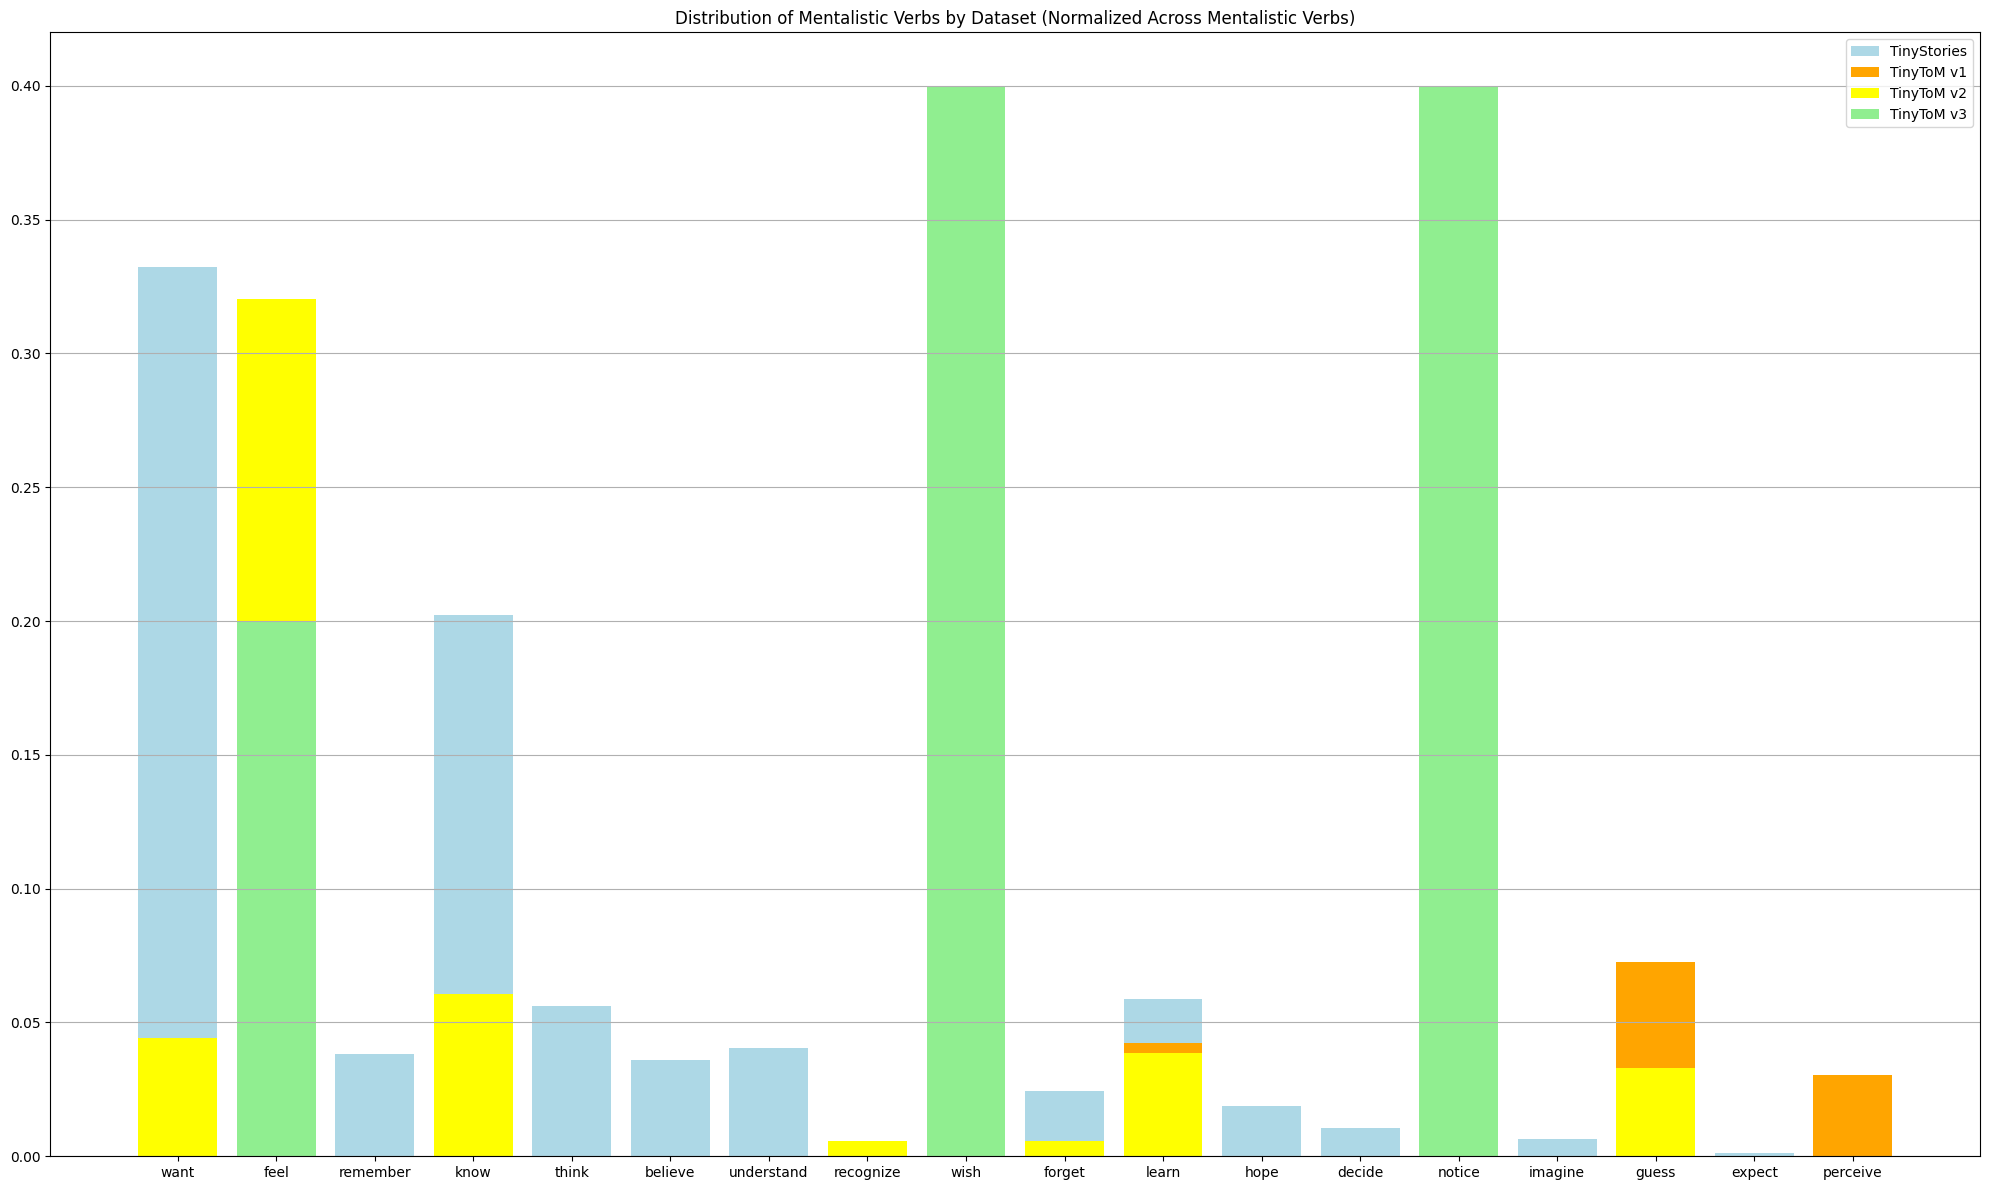

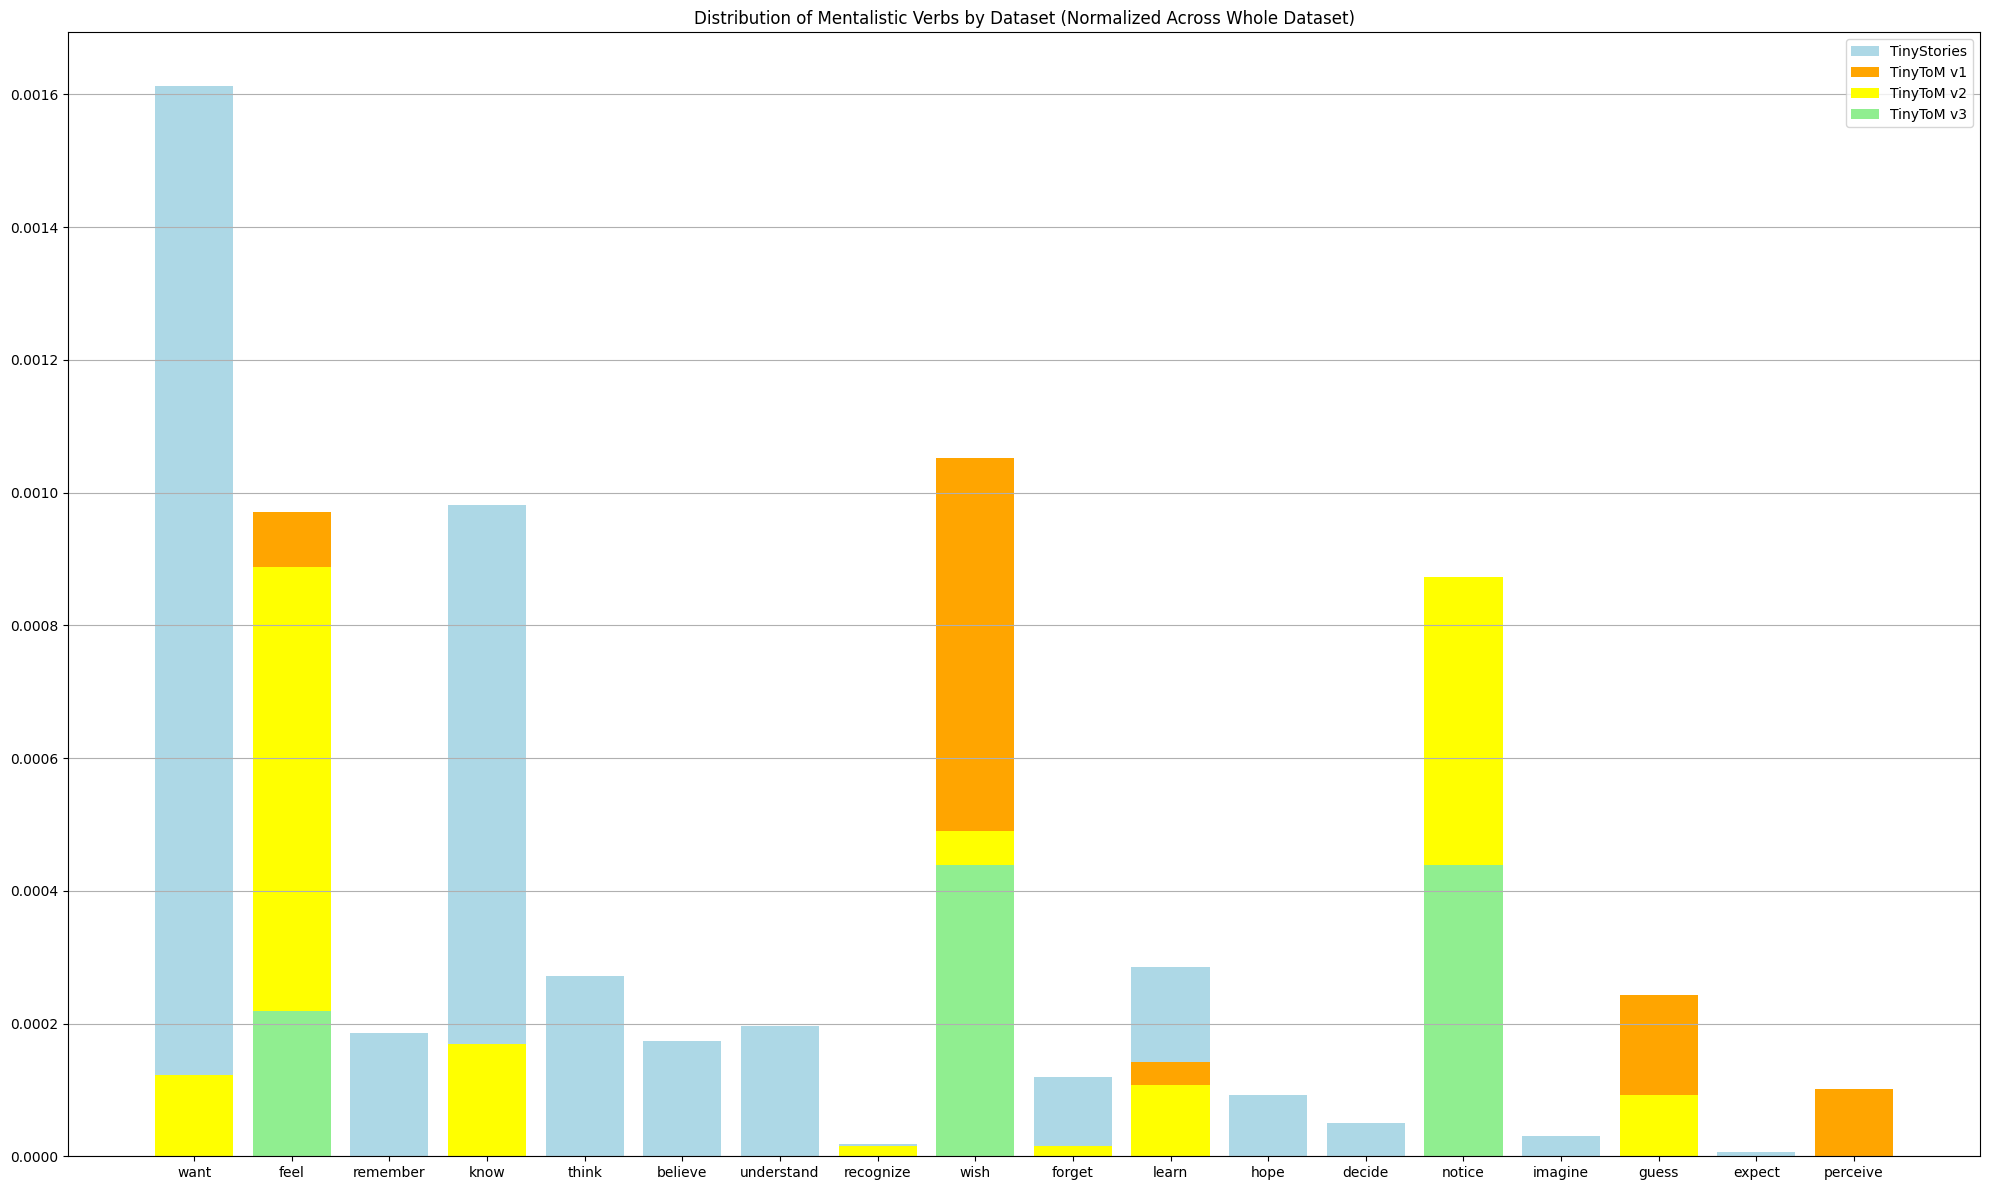

In [85]:
beliefs_keywords = ["know", "think", "learn", "understand", "perceive", "believe", "forget", "guess", "notice", "recognize"]
emotion_keywords = ["feel"]
desire_keywords = ["want", "wish", "hope", "decide", "prefer"]
others_keywords = ["imagine", "expect", "remember"]
all = beliefs_keywords + emotion_keywords + desire_keywords + others_keywords

mental_verbs_tinystories = [pair for pair in word_counts_tinystories.items() if pair[0] in all]
mental_total_tinystories = sum([x[1] for x in mental_verbs_tinystories])
mental_verbs_tinystories_normalized = [(pair[0], pair[1]/mental_total_tinystories) for pair in mental_verbs_tinystories]
print(mental_verbs_tinystories_normalized)

mental_verbs_tinytom_v1 = [pair for pair in word_counts_tinytom_v1.items() if pair[0] in all]
mental_total_tinytom_v1 = sum([x[1] for x in mental_verbs_tinytom_v1])
mental_verbs_tinytom_v1_normalized = [(pair[0], pair[1]/mental_total_tinytom_v1) for pair in mental_verbs_tinytom_v1]
print(mental_verbs_tinytom_v1_normalized)

mental_verbs_tinytom_v2 = [pair for pair in word_counts_tinytom_v2.items() if pair[0] in all]
mental_total_tinytom_v2 = sum([x[1] for x in mental_verbs_tinytom_v2])
mental_verbs_tinytom_v2_normalized = [(pair[0], pair[1]/mental_total_tinytom_v2) for pair in mental_verbs_tinytom_v2]
print(mental_verbs_tinytom_v2_normalized)

mental_verbs_tinytom_v3 = [pair for pair in word_counts_tinytom_v3.items() if pair[0] in all]
mental_total_tinytom_v3 = sum([x[1] for x in mental_verbs_tinytom_v3])
mental_verbs_tinytom_v3_normalized = [(pair[0], pair[1]/mental_total_tinytom_v3) for pair in mental_verbs_tinytom_v3]
print(mental_verbs_tinytom_v3_normalized)

# Create the bar plot
fig, ax = plt.subplots(figsize=(20,12))
ax.bar([x[0] for x in mental_verbs_tinystories_normalized], [x[1] for x in mental_verbs_tinystories_normalized], label="TinyStories", align='center', ecolor='black', capsize=10, color='lightblue')
ax.bar([x[0] for x in mental_verbs_tinytom_v1_normalized], [x[1] for x in mental_verbs_tinytom_v1_normalized], label="TinyToM v1", align='center', ecolor='black', capsize=10, color='orange')
ax.bar([x[0] for x in mental_verbs_tinytom_v2_normalized], [x[1] for x in mental_verbs_tinytom_v2_normalized], label="TinyToM v2", align='center', ecolor='black', capsize=10, color='yellow')
ax.bar([x[0] for x in mental_verbs_tinytom_v3_normalized], [x[1] for x in mental_verbs_tinytom_v3_normalized], label="TinyToM v3", align='center', ecolor='black', capsize=10, color='lightgreen')

# ax.set_ylabel('Percentage')
ax.set_title('Distribution of Mentalistic Verbs by Dataset (Normalized Across Mentalistic Verbs)')
ax.yaxis.grid(True)
ax.legend(loc="upper right")

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()


mental_verbs_tinystories_normalized = [(pair[0], pair[1]/tinystories_len) for pair in mental_verbs_tinystories]
mental_verbs_tinytom_v1_normalized = [(pair[0], pair[1]/v1_len) for pair in mental_verbs_tinytom_v1]
mental_verbs_tinytom_v2_normalized = [(pair[0], pair[1]/v2_len) for pair in mental_verbs_tinytom_v2]
mental_verbs_tinytom_v3_normalized = [(pair[0], pair[1]/v3_len) for pair in mental_verbs_tinytom_v3]

# Create the bar plot
fig, ax = plt.subplots(figsize=(20,12))
ax.bar([x[0] for x in mental_verbs_tinystories_normalized], [x[1] for x in mental_verbs_tinystories_normalized], label="TinyStories", align='center', ecolor='black', capsize=10, color='lightblue')
ax.bar([x[0] for x in mental_verbs_tinytom_v1_normalized], [x[1] for x in mental_verbs_tinytom_v1_normalized], label="TinyToM v1", align='center', ecolor='black', capsize=10, color='orange')
ax.bar([x[0] for x in mental_verbs_tinytom_v2_normalized], [x[1] for x in mental_verbs_tinytom_v2_normalized], label="TinyToM v2", align='center', ecolor='black', capsize=10, color='yellow')
ax.bar([x[0] for x in mental_verbs_tinytom_v3_normalized], [x[1] for x in mental_verbs_tinytom_v3_normalized], label="TinyToM v3", align='center', ecolor='black', capsize=10, color='lightgreen')

# ax.set_ylabel('Percentage')
ax.set_title('Distribution of Mentalistic Verbs by Dataset (Normalized Across Whole Dataset)')
ax.yaxis.grid(True)
ax.legend(loc="upper right")

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()

## Look at perplexity

In [3]:
import evaluate
perplexity = evaluate.load("perplexity", module_type="metric")

/Users/sarahbloom/miniconda3/envs/tinytom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
print(list(word_counts_tinystories.keys()))
print(in_tinytom_v1_not_tinystories)

['one', 'day', 'a', 'little', 'girl', 'named', 'lily', 'found', 'needle', 'in', 'her', 'room', 'she', 'knew', 'it', 'was', 'difficult', 'to', 'play', 'with', 'because', 'sharp', 'wanted', 'share', 'the', 'mom', 'so', 'could', 'sew', 'button', 'on', 'shirt', 'went', 'and', 'said', 'i', 'this', 'can', 'you', 'me', 'my', 'smiled', 'yes', 'we', 'fix', 'your', 'together', 'they', 'shared', 'sewed', 'lilys', 'not', 'for', 'them', 'were', 'sharing', 'helping', 'each', 'other', 'after', 'finished', 'thanked', 'fixing', 'both', 'felt', 'happy', 'had', 'worked', 'once', 'upon', 'time', 'there', 'car', 'beep', 'loved', 'go', 'fast', 'sun', 'healthy', 'he', 'always', 'good', 'fuel', 'made', 'strong', 'driving', 'park', 'when', 'saw', 'big', 'tree', 'many', 'leaves', 'that', 'falling', 'liked', 'how', 'fall', 'drove', 'under', 'watched', 'him', 'laughed', 'beeped', 'his', 'horn', 'played', 'all', 'home', 'needed', 'more', 'place', 'got', 'now', 'ready', 'again', 'next', 'lived', 'happily', 'ever', 

In [61]:
import matplotlib.pyplot as plt

def get_perplexity(words):
    results = perplexity.compute(model_id='roneneldan/TinyStories-28M',
                             add_start_token=True,
                            #  batch_size=1,words
                             predictions=words)
    return results['perplexities'], results['mean_perplexity']

ppl_tinystories = get_perplexity(list(word_counts_tinystories.keys()))

ppl_v1 = get_perplexity(in_tinytom_v1_not_tinystories)
ppl_v2 = get_perplexity(in_tinytom_v2_not_tinystories)
ppl_v3 = get_perplexity(in_tinytom_v3_not_tinystories)

ppl_v3_no_names = get_perplexity(in_tinytom_v3_not_tinystories_no_names)
ppl_v2_no_names = get_perplexity(in_tinytom_v2_not_tinystories_no_names)
ppl_v1_no_names = get_perplexity(in_tinytom_v1_not_tinystories_no_names)

Using pad_token, but it is not set yet.
100%|██████████| 609/609 [00:47<00:00, 12.81it/s]
Using pad_token, but it is not set yet.
100%|██████████| 16/16 [00:01<00:00, 15.67it/s]
Using pad_token, but it is not set yet.
100%|██████████| 25/25 [00:01<00:00, 14.68it/s]
Using pad_token, but it is not set yet.
100%|██████████| 3/3 [00:00<00:00, 16.80it/s]
Using pad_token, but it is not set yet.
100%|██████████| 3/3 [00:00<00:00, 21.18it/s]
Using pad_token, but it is not set yet.
100%|██████████| 19/19 [00:01<00:00, 13.88it/s]
Using pad_token, but it is not set yet.
100%|██████████| 13/13 [00:00<00:00, 16.15it/s]


In [ ]:
ppl_v1_all = get_perplexity(list(word_counts_tinytom_v1.keys()))

Perplexity TinyStories words: 153720747804.69913
Perplexity tinytom-v1 words: 12300928804.839876
Perplexity tinytom-v2 words: 141920305158.0811
Perplexity tinytom-v3 words: 9754897921.178589


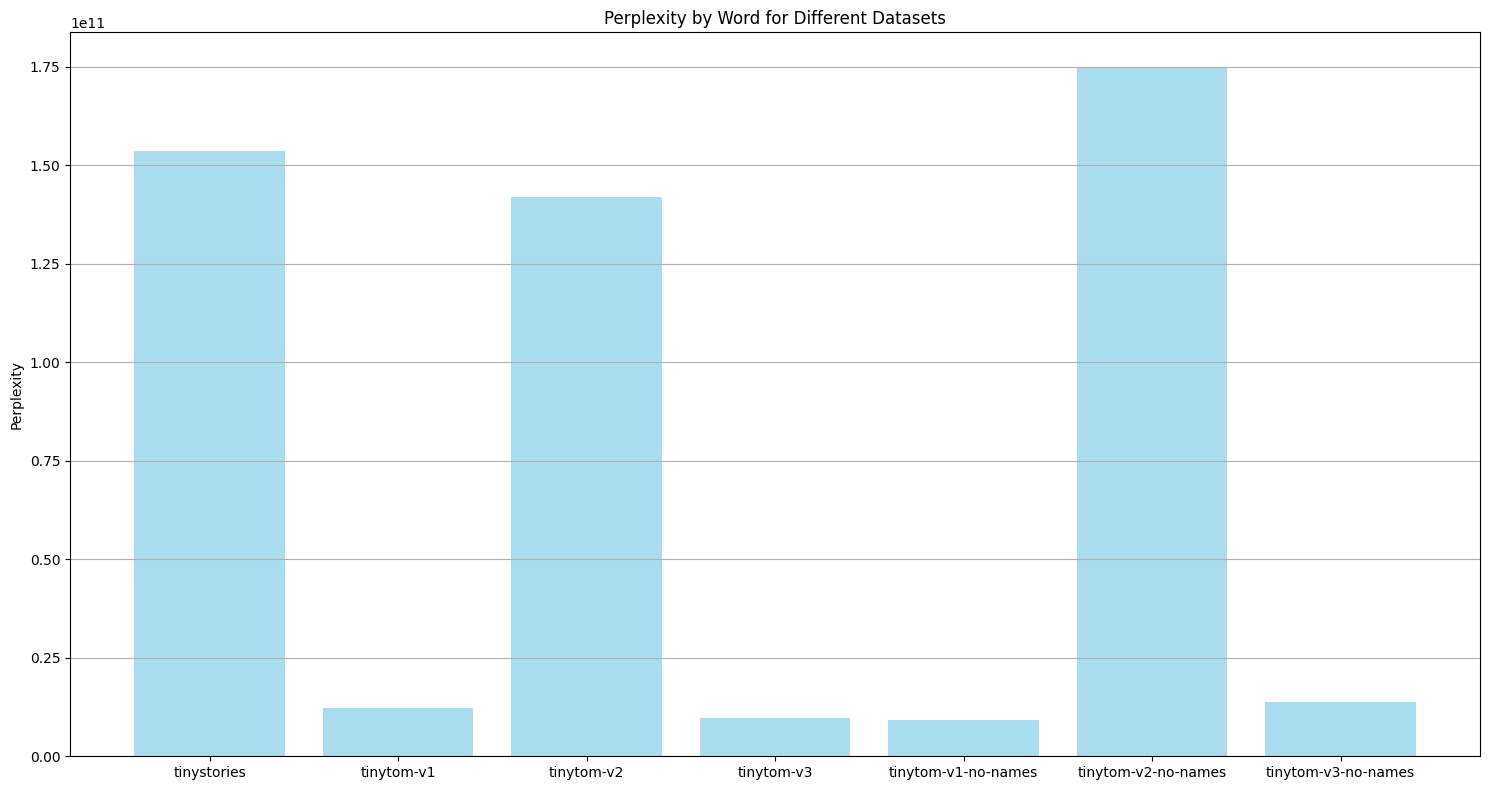

In [86]:
print("Perplexity TinyStories words:", ppl_tinystories[1])
print("Perplexity tinytom-v1 words:", ppl_v1[1])
print("Perplexity tinytom-v2 words:", ppl_v2[1])
print("Perplexity tinytom-v3 words:", ppl_v3[1])

names = ['tinystories', 'tinytom-v1', 'tinytom-v2', 'tinytom-v3', 'tinytom-v1-no-names', 'tinytom-v2-no-names', 'tinytom-v3-no-names']
means = [ppl_tinystories[1], ppl_v1[1], ppl_v2[1], ppl_v3[1], ppl_v1_no_names[1], ppl_v2_no_names[1], ppl_v3_no_names[1]]

# Create the bar plot with error bars
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(names, means, align='center', alpha=0.7, ecolor='black', capsize=10, color='skyblue')

ax.set_ylabel('Perplexity')
ax.set_title('Perplexity by Word for Different Datasets')
ax.yaxis.grid(True)

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()